In [ ]:
# Only if using google drive for files
from google.colab import drive
drive.mount('/content/drive')
# https://www.kaggle.com/datasets/anshtanwar/pets-facial-expression-dataset

Mounted at /content/drive


In [ ]:
# Define the path to the dataset folders
main_path = "https://github.com/hastighsh/Pet-Emotion-Prediction/tree/031eae46980b7ba5f4bcd71da507bec8a9413c8f/pet-dataset/Master%20Folder"
train_path = f'{main_path}/train/'
val_path = f'{main_path}/valid/'
test_path = f'{main_path}/test/'

paths = {
    'train': train_path,
    'val': val_path,
    'test': test_path
}


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import time


In [ ]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
image_datasets = {x: ImageFolder(paths[x], data_transforms[x]) for x in ['train', 'val', 'test']}

In [ ]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=(x == 'train'), num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(class_names)

{'train': 1019, 'val': 36, 'test': 38}
['Angry', 'Other', 'Sad', 'happy']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Densenet161

In [ ]:
dense_model = models.densenet161(weights='DenseNet161_Weights.DEFAULT')

# Freeze all layers except the final classification layer
for name, param in dense_model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = dense_model.classifier.in_features
print(num_ftrs)

classifier = nn.Sequential(
  nn.Linear(in_features=num_ftrs, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=1024, out_features=4),
  nn.LogSoftmax(dim=1)
)

dense_model.classifier = classifier
dense_model.classifier

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(dense_model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
dense_model = dense_model.to(device)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 90.7MB/s]


2208


In [ ]:
def train_model(model, dataloaders, name, num_epochs=10):
  start = time.time()
  # Training loop
  best_accuracy = 0
  history = {'train': [], 'val': []}
  for epoch in range(num_epochs):
      for phase in ['train', 'val']:
          model.train() if phase == 'train' else model.eval()

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()

              with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  if phase == 'train':
                      loss.backward()
                      optimizer.step()
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]
          if phase == 'val' and epoch_acc >= best_accuracy:
            torch.save(model.state_dict(), f'best-{name}-parameters.pt') # official recommended
            best_accuracy = epoch_acc

          history[phase].append((epoch_acc, epoch_loss))
          print(f'Epoch {epoch}: {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
  end = time.time()
  print("Training complete!")
  print(f"Elasped time: {end - start} seconds")
  return history

In [ ]:
history = train_model(dense_model, dataloaders, "dense", 50)
dense_model.load_state_dict(torch.load("best-dense-parameters.pt"))

Epoch 0: train Loss: 1.3492 Acc: 0.3621
Epoch 0: val Loss: 1.3082 Acc: 0.3611
Epoch 1: train Loss: 1.2456 Acc: 0.4642
Epoch 1: val Loss: 1.2524 Acc: 0.4167
Epoch 2: train Loss: 1.1748 Acc: 0.5123
Epoch 2: val Loss: 1.1938 Acc: 0.5000
Epoch 3: train Loss: 1.1153 Acc: 0.5388
Epoch 3: val Loss: 1.2146 Acc: 0.4722
Epoch 4: train Loss: 1.0888 Acc: 0.5535
Epoch 4: val Loss: 1.2303 Acc: 0.4722
Epoch 5: train Loss: 1.0425 Acc: 0.5662
Epoch 5: val Loss: 1.2161 Acc: 0.4722
Epoch 6: train Loss: 1.0057 Acc: 0.6232
Epoch 6: val Loss: 1.2150 Acc: 0.4722
Epoch 7: train Loss: 0.9906 Acc: 0.6163
Epoch 7: val Loss: 1.2484 Acc: 0.4722
Epoch 8: train Loss: 0.9278 Acc: 0.6398
Epoch 8: val Loss: 1.2164 Acc: 0.4722
Epoch 9: train Loss: 0.9119 Acc: 0.6575
Epoch 9: val Loss: 1.2538 Acc: 0.5000
Epoch 10: train Loss: 0.8840 Acc: 0.6663
Epoch 10: val Loss: 1.2354 Acc: 0.4722
Epoch 11: train Loss: 0.8933 Acc: 0.6703
Epoch 11: val Loss: 1.2633 Acc: 0.4444
Epoch 12: train Loss: 0.8689 Acc: 0.6811
Epoch 12: val Loss:

<All keys matched successfully>

In [ ]:
# Test on unseen image
image_path = "/content/drive/MyDrive/pet-dataset/Master Folder/test/happy/011.jpg"
image = Image.open(image_path)

input_tensor = data_transforms['test'](image)
input_batch = input_tensor.unsqueeze(0)

In [ ]:
# Perform inference
with torch.no_grad():
    output = dense_model(input_batch.to(device))

# Get the predicted class
_, predicted_class = torch.max(output, 1)

# Map the predicted class to the class name
class_names = ['Angry', 'Other', 'Sad', 'happy']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: happy


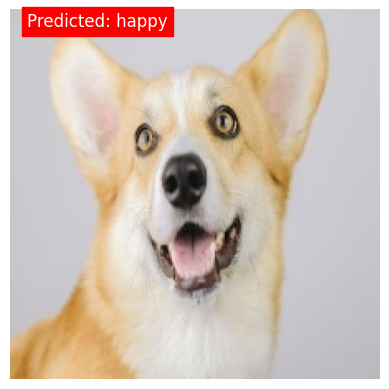

In [ ]:
# Display the image with the predicted class name
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

In [ ]:
def test_model(model, dataloaders):
    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:

            outputs = model(inputs.to(device))

            predicted = torch.max(outputs.data, 1)[1]

            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print(f'Accuracy of the network on the {dataset_sizes["test"]} test images: {100 * correct // total} %')

In [ ]:
test_model(dense_model, dataloaders)

Accuracy of the network on the 38 test images: 52 %


In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    train_accuracies = [x[0].cpu().data for x in history['train']]
    val_accuracies = [x[0].cpu().data for x in history['val']]
    plt.plot(train_accuracies, '-x', label='train')
    plt.plot(val_accuracies, '-x', label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="upper left")
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x[1] for x in history['train']]
    val_losses = [x[1] for x in history['val']]
    plt.plot(train_losses, '-bx', label='train')
    plt.plot(val_losses, '-rx', label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc="upper left")
    plt.title('Loss vs. No. of epochs');


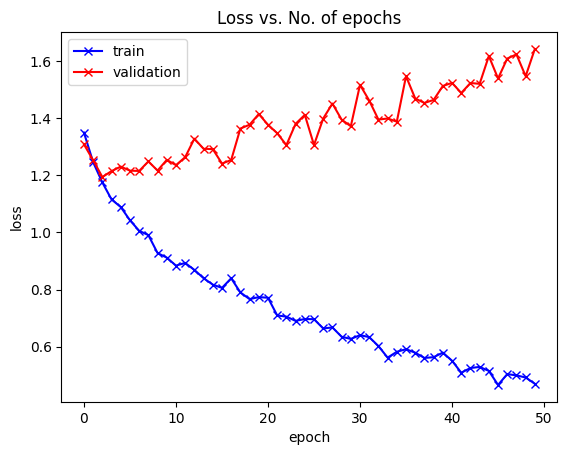

In [ ]:
plot_losses(history)

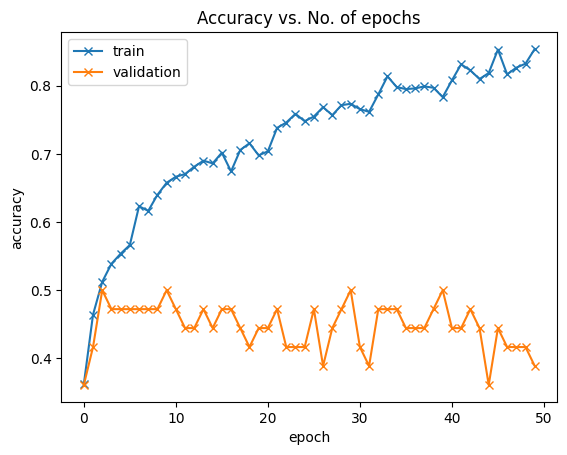

In [ ]:
plot_accuracies(history)

## Resnet50

In [ ]:
res_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Freeze all layers except the final classification layer
for name, param in res_model.named_parameters():
    if "fc" in name:  # Unfreeze the final classification layer
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = res_model.fc.in_features
print(num_ftrs)
classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.ReLU(),
  nn.Dropout(p=0.4),
  nn.Linear(in_features=1024, out_features=4),
  nn.LogSoftmax(dim=1)
)

res_model.fc = classifier

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(res_model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
res_model = res_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.4MB/s]


2048


In [ ]:
history = train_model(res_model, dataloaders, "res", 50)
res_model.load_state_dict(torch.load("best-res-parameters.pt"))
test_model(res_model, dataloaders)

Epoch 0: train Loss: 1.2936 Acc: 0.3974
Epoch 0: val Loss: 1.2232 Acc: 0.3611
Epoch 1: train Loss: 1.0979 Acc: 0.5407
Epoch 1: val Loss: 1.3882 Acc: 0.3889
Epoch 2: train Loss: 1.0378 Acc: 0.5653
Epoch 2: val Loss: 1.2974 Acc: 0.3889
Epoch 3: train Loss: 0.9830 Acc: 0.6045
Epoch 3: val Loss: 1.3201 Acc: 0.3889
Epoch 4: train Loss: 0.8963 Acc: 0.6330
Epoch 4: val Loss: 1.5120 Acc: 0.4444
Epoch 5: train Loss: 0.8272 Acc: 0.6811
Epoch 5: val Loss: 1.4068 Acc: 0.4167
Epoch 6: train Loss: 0.7993 Acc: 0.6791
Epoch 6: val Loss: 1.4433 Acc: 0.4167
Epoch 7: train Loss: 0.7171 Acc: 0.7321
Epoch 7: val Loss: 1.5190 Acc: 0.4444
Epoch 8: train Loss: 0.7319 Acc: 0.7203
Epoch 8: val Loss: 1.4072 Acc: 0.4167
Epoch 9: train Loss: 0.6785 Acc: 0.7301
Epoch 9: val Loss: 1.5486 Acc: 0.4167
Epoch 10: train Loss: 0.7149 Acc: 0.7193
Epoch 10: val Loss: 1.7341 Acc: 0.3611
Epoch 11: train Loss: 0.6526 Acc: 0.7448
Epoch 11: val Loss: 1.6856 Acc: 0.4167
Epoch 12: train Loss: 0.6053 Acc: 0.7674
Epoch 12: val Loss:

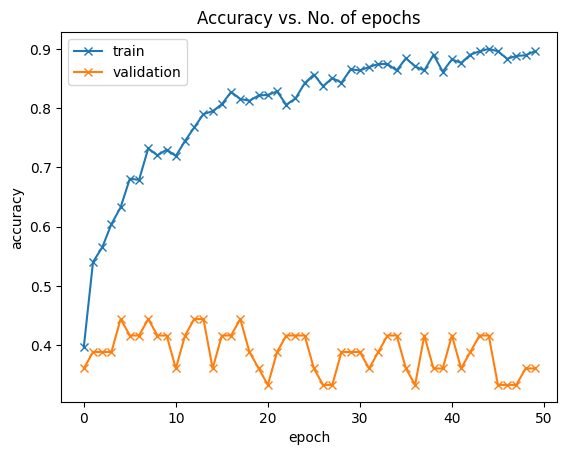

In [ ]:
plot_accuracies(history)

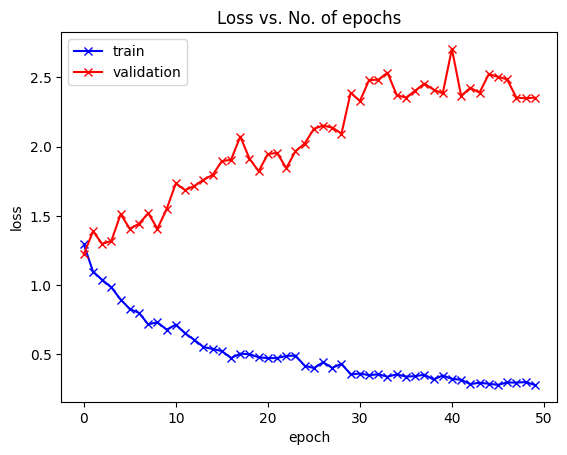

In [ ]:
plot_losses(history)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
	#  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
      super(Net, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=(5, 5))
      self.batch1 = nn.BatchNorm2d(20)
      self.relu1 = nn.ReLU()
      self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

      self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
      self.batch2 = nn.BatchNorm2d(50)
      self.relu2 = nn.ReLU()
      self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

      self.fc1 = nn.Linear(in_features=140450, out_features=1024)
      self.relu3 = nn.ReLU()
      self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
      self.logSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      x = self.conv1(x)
      x = self.batch1(x)
      x = self.relu1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.batch2(x)
      x = self.relu2(x)
      x = self.maxpool2(x)
      x = torch.flatten(x, 1)
      x = self.fc1(x)
      x = self.relu3(x)
      x = self.fc2(x)
      output = self.logSoftmax(x)
      return output

model = Net(4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
model = model.to(device)

In [ ]:
history = train_model(model, dataloaders, "model", 50)
model.load_state_dict(torch.load("best-model-parameters.pt"))
test_model(model, dataloaders)

Epoch 0: train Loss: 36.6877 Acc: 0.2630
Epoch 0: val Loss: 9.5402 Acc: 0.2778
Epoch 1: train Loss: 4.1013 Acc: 0.2758
Epoch 1: val Loss: 2.2983 Acc: 0.1944
Epoch 2: train Loss: 1.9658 Acc: 0.2669
Epoch 2: val Loss: 1.4994 Acc: 0.2778
Epoch 3: train Loss: 1.4580 Acc: 0.3199
Epoch 3: val Loss: 1.4133 Acc: 0.3333
Epoch 4: train Loss: 1.3760 Acc: 0.3238
Epoch 4: val Loss: 1.5363 Acc: 0.2500
Epoch 5: train Loss: 1.3831 Acc: 0.3366
Epoch 5: val Loss: 1.5058 Acc: 0.1667
Epoch 6: train Loss: 1.3832 Acc: 0.3248
Epoch 6: val Loss: 1.4142 Acc: 0.2778
Epoch 7: train Loss: 1.3675 Acc: 0.3140
Epoch 7: val Loss: 1.3110 Acc: 0.3611
Epoch 8: train Loss: 1.3465 Acc: 0.3435
Epoch 8: val Loss: 1.3093 Acc: 0.2778
Epoch 9: train Loss: 1.3236 Acc: 0.3837
Epoch 9: val Loss: 1.3459 Acc: 0.3056
Epoch 10: train Loss: 1.3461 Acc: 0.3415
Epoch 10: val Loss: 1.3700 Acc: 0.3333
Epoch 11: train Loss: 1.3191 Acc: 0.3719
Epoch 11: val Loss: 1.3374 Acc: 0.3056
Epoch 12: train Loss: 1.3268 Acc: 0.3857
Epoch 12: val Loss

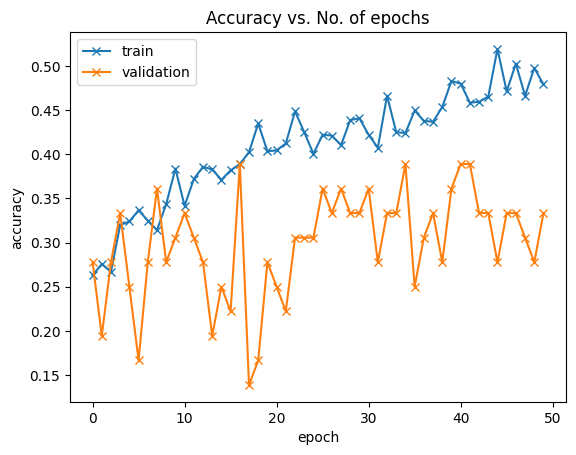

In [ ]:
plot_accuracies(history)

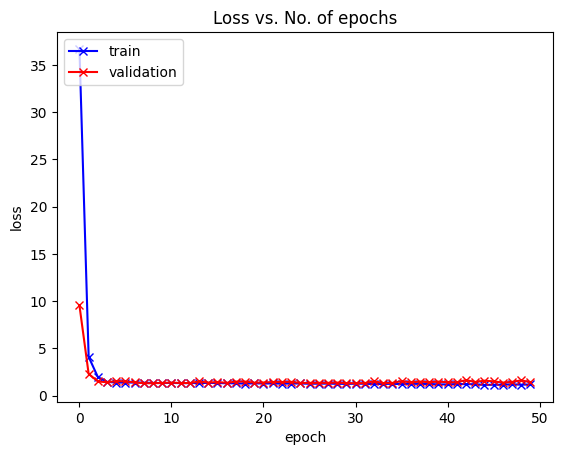

In [ ]:
plot_losses(history)

## Ensemble model

In [ ]:
# class MyEnsemble(nn.Module):

#     def __init__(self, modelA, modelB, modelC, input_dim):
#         super(MyEnsemble, self).__init__()
#         self.modelA = modelA
#         self.modelB = modelB
#         self.modelC = modelC

#         self.fc1 = nn.Linear(input_dim, 4)

#     def forward(self, x):
#         out1 = self.modelA(x)
#         out2 = self.modelB(x)
#         out3 = self.modelC(x)

#         out = out1 + out2
#         x = self.fc1(out)
#         return torch.softmax(x, dim=1)

In [ ]:
# ensemble_model = MyEnsemble(dense_model, res_model, model, 4)

In [ ]:
# ensemble_model.to(device)
# optimizer = optim.Adam(model.parameters(),lr=0.003)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
# history = train_model(ensemble_model, dataloaders, "ensemble",)

In [ ]:
# test_model(ensemble_model, dataloaders)
# trash accuracy